# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (1er entrega)

## Fecha de entrega

*Ingresar fecha*

## Integrantes

* <Martín, Romeo>
* <Rómulo, Achulli Orccori>
* <Luca, Falchini>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la funcion de ejemplo (`ruidoRosa_voss`).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) completado y con las celdas ejecutas a myommi@untref.edu.ar.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io.wavfile import write
from scipy import signal
import soundfile as sf
import sounddevice as sd

## Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

![Espectro del ruido rosa](./image44.png)
<center><b>Fig 1.</b> Espectro del ruido rosa.</center>

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). 

**Consigna:** modificar la función original para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (Ayuda: la longitud de la señal sera el producto entre ambos). La función debe guardar el archivo de audio .wav de la señal generada y devolver el vector de datos de la señal.

In [2]:
def ruidoRosa_voss_modified(t, fs, ncols=16):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney(https://www.dsprelated.com/showabstract/3933.php).
    
    .. Nota:: si 'ruidoRosa.wav' existe, este será sobreescrito
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    rcols: int
        Determina el número de fuentes a aleatorias a agregar.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar un `.wav` desde un numpy array de 10 segundos con ruido rosa a una 
    frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        import soundfile as sf
        from scipy.io.wavfile import write
        from scipy import signal
        
        ruidoRosa_voss(10)
    """
    nrows = int(t*fs)

    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # el numero total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    
    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)
    
    ## Centrado de el array en 0
    total = total - total.mean()
    
    ## Normalizado
    valor_max = max(abs(max(total)),abs(min(total)))
    total = total / valor_max
    
    # Agregar generación de archivo de audio .wav
    write('ruidoRosa.wav', fs, total)  # Save as WAV file 
    
    
    return total

Llamar la función.

In [3]:
# completar
# Defino tiempo (t) y frecuencia de muestreo (fs)
t = 10
fs = 44100     
ruidoRosa_voss_modified(t, fs)

0         0.232171
1         0.121779
2         0.308949
3         0.179497
4         0.127421
            ...   
440995   -0.175831
440996   -0.202219
440997   -0.299922
440998   -0.227091
440999   -0.038048
Length: 441000, dtype: float64

Realizar una función para visualizar el dominio temporal de la señal.

In [4]:
#signal = ruidoRosa_voss_modified(t, fs)
def time_domain_plot(signal):
    signal = ruidoRosa_voss_modified(t, fs)
    time = np.linspace(0, t, num=t*fs)  # Objeto Numpy para la duración en el eje x
    
    # Grafico
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, linewidth=0.5)
    plt.title('Gráfico Ruido Rosa Dominio del tiempo')
    plt.ylabel('Amplitud')
    plt.xlabel('Tiempo [s]')
    plt.xlim(0, 10) # Limitamos el eje x a la duración del audio en segundos
    plt.ylim(-2, 2)
    plt.show()
    return()

Llamar a la función.

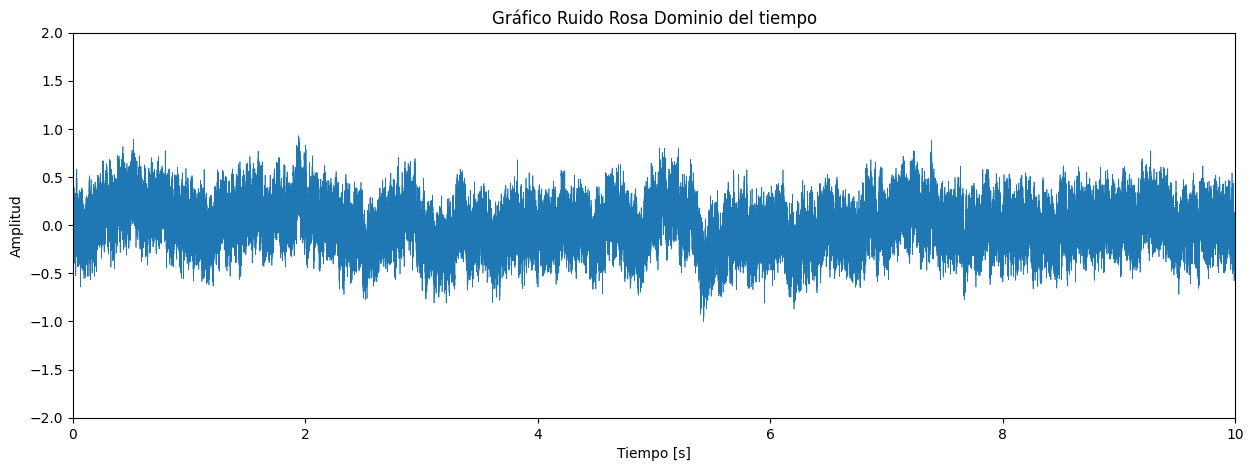

()

In [5]:
# completar
time_domain_plot(signal)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

![spec](./Plot%20Ruido%20Rosa%20Audacity.png)

Reproducir resultado.

In [6]:
# Reproducción de ruido Rosa

filename = 'ruidoRosa.wav'
# Extract data and sampling rate from file
data, fs = sf.read(filename, dtype='float32')  
sd.play(data, fs)
status = sd.wait()  # Wait until file is done playing

> Solo a modo de comentario, un **método alternativo** es utilizando un filtro en el siguiente [link](https://ccrma.stanford.edu/~jos/sasp/Example_Synthesis_1_F_Noise.html) se presenta la implementación en Matlab/Octave.

## Funcion de generación de sine sweep logaritmico + filtro inverso
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola de salva, paper gun ([Paper Popper](https://en.wikipedia.org/wiki/Paper_popper)), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el sweep rate $R$: 

\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\tag{2}
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).


<div align="center">
    <img src="./image43.png">
</div>
<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 

<div align="center">
    <img src="./image46.png">
</div>
<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>

Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{3}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{4}
\end{equation}
m
entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{5}
\end{equation}

**Consigna:** realizar una función generadora de un sine sweep y su filtro inverso, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros, usando la función anteriormente creada. Recordar almacenar los audios. Agregar docstring que indique claramente los parametros de entrada y salida.

In [13]:
# Completar

# Defino la función
def log_sweep_invfilter(f1, f2, t_sweep, fs_sweep):
    """
    Genera Sine Sweep Logarítmico
    
    .. Nota:: si 'SineSweepLog.wav' existe, este será sobreescrito
    
    Parametros
    ----------
    t_sweep: int  
        Duración en segundos del sweep
    fs_sweep: int
        Frecuencia de muestreo
    f1: int
        Frecuencia inferior
    f2: int
        Frecuencia superior
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar dos archivos `.wav` de 10 segundos con una señal Sine Sweep Logarítmica y un Filtro Inverso 
    entre las frecuencias de 20 a 4000 Hz a una frecuencia de muestreo de 44100 Hz.
    
    import numpy as np
    from matplotlib import pyplot as plt
    import soundfile as sf
    from scipy.io.wavfile import write
    from scipy import signal

    log_sweep_invfilter(20, 4000, 10, 44100)

    """
    t_swipe_arange = np.arange(0, t_sweep*fs_sweep)/fs_sweep  # Arreglo de muestreos
    R = np.log(f2/f1)  # Sweep rate
    K = t_sweep*2*np.pi*f1/R
    L = t_sweep/R
    w = (K/L)*np.exp(t_swipe_arange/L)
    m = f1/w
    # Sine Sweep Logarítmico
    x = np.sin(K*(np.exp(t_swipe_arange/L-1)))
    
    # Filtro Inverso
    k_t = x[::-1]*m
    
    # Gráficos
    plt.figure(figsize=(15,10))
    # Gráfico Sine Sweep Logarítmico
    plt.subplot(2,1,1)
    plt.grid()
    plt.plot(t_swipe_arange, x, linewidth=0.5)
    plt.title('Sine Sweep Logarítmico')
    plt.ylabel('Amplitud')
    plt.xlabel('Tiempo [s]')
    # Gráfico Filtro Inverso
    plt.subplot(2,1,2)
    plt.grid()
    plt.plot(t_swipe_arange, k_t, linewidth=0.5)
    plt.title('Filtro Inverso')
    plt.ylabel('Amplitud')
    plt.xlabel('Tiempo [s]')

    plt.show()

    # Agregar generación de archivo de audio .wav
    write('SineSweepLog.wav', fs_sweep, x)  # Save as WAV file 
    write('InvFilter.wav', fs_sweep, k_t)  # Save as WAV file 

    
    return x, k_t


Llamar la función.

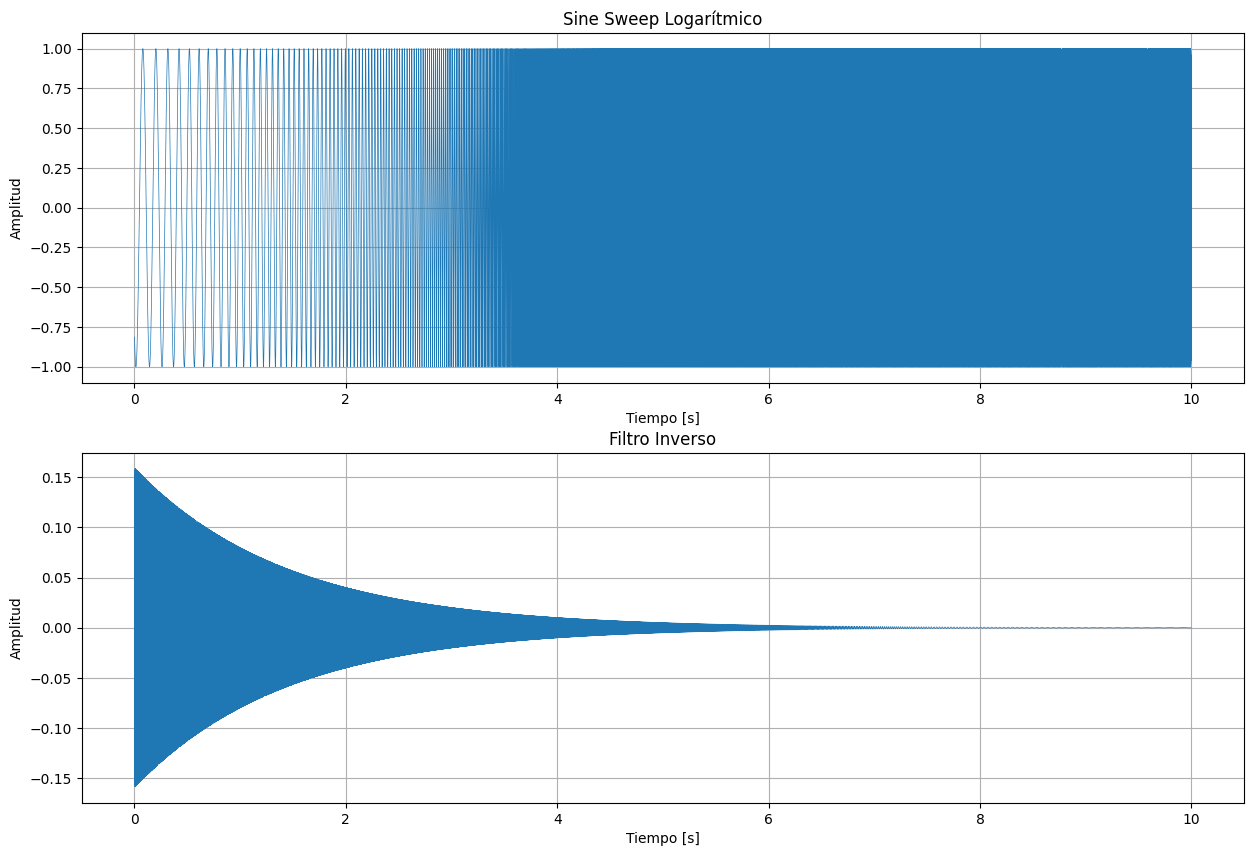

(array([-0.81342851, -0.81403781, -0.81464623, ..., -0.95153934,
        -0.74139828,  0.21149325]),
 array([ 3.36601955e-02, -1.17995352e-01, -1.51437446e-01, ...,
        -1.29661068e-04, -1.29562201e-04, -1.29463196e-04]))

In [14]:
# completar

# Defino las variables
t_sweep = 10  # Duración en segundos del sweep
fs_sweep = 44100  # Frecuencia de muestreo
f1 = 20  # Frecuencia inferior
f2 = 20000  # Frecuencia superior

log_sweep_invfilter(f1, f2, t_sweep, fs_sweep)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

Gráfico de Sine Sweep Logarítmico

![](./SineSweepLog.png)

Gráfico de Filtro Inverso

![](./InvFilter.png)

Reproducir resultados.

In [10]:
# completar
# Reproducción de Sine Sweep Logarítmico

filename = 'SineSweepLog.wav'
# Extract data and sampling rate from file
data, fs = sf.read(filename, dtype='float32')  
sd.play(data, fs)
status = sd.wait()  # Wait until file is done playing

In [11]:
# completar

# Reproducción de Filtro Inverso

filename = 'InvFilter.wav'
# Extract data and sampling rate from file
data, fs = sf.read(filename, dtype='float32')  
sd.play(data, fs)
status = sd.wait()  # Wait until file is done playing

## Función adquisicion y reproducción
**Consigna**: la función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Clase de audio](../../clases/clase_6/600_audio.ipynb)
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)

In [18]:
# Ver la lista de hardwares de audio
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Micrófono (2- M-Track), MME (2 in, 0 out)
   2 Micrófono (USB Microphone), MME (2 in, 0 out)
   3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  4 Altavoces (2- M-Track), MME (0 in, 2 out)
   5 Controlador primario de captura de sonido, Windows DirectSound (2 in, 0 out)
   6 Micrófono (2- M-Track), Windows DirectSound (2 in, 0 out)
   7 Micrófono (USB Microphone), Windows DirectSound (2 in, 0 out)
   8 Controlador primario de sonido, Windows DirectSound (0 in, 2 out)
   9 Altavoces (2- M-Track), Windows DirectSound (0 in, 2 out)
  10 ASIO4ALL v2, ASIO (2 in, 8 out)
  11 FL Studio ASIO, ASIO (2 in, 2 out)
  12 Generic Low Latency ASIO Driver, ASIO (1 in, 0 out)
  13 Altavoces (2- M-Track), Windows WASAPI (0 in, 2 out)
  14 Micrófono (2- M-Track), Windows WASAPI (2 in, 0 out)
  15 Micrófono (USB Microphone), Windows WASAPI (1 in, 0 out)
  16 Speakers (Realtek HD Audio output), Windows WDM-KS (0 in, 8 out)
  17 Mezcla esté

In [30]:
# Completar
duration = 5.5  # seconds
index_device = (1, 4)  # Seleccionar el indice del dispositivo de audio
sd.default.samplerate = 44100

def callback(indata, outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata

    return outdata

with sd.Stream(device=index_device, channels=2, callback=callback):
    sd.sleep(int(duration * 1000))

Llamar la función.

In [ ]:
# completar

¿Cómo se podría medir la latencia de la función?

In [ ]:
# Completar